### GLM : Hierarchical Linear Regression

In [1]:
## Import useful libraries
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import scipy
import pymc3 as pm
import theano
import theano.tensor as T
%matplotlib inline

import warnings
#warnings.filterwarnings('ignore')

In [2]:
import json
import matplotlib
import warnings

warnings.simplefilter('ignore')

root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"
s = json.load(open(root))
matplotlib.rcParams.update(s)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

In [3]:
## Import the data and extract Minnesota's data

data = pd.read_csv("/Users/Kenneth-Aristide/anaconda3/bin/python_prog/pymc3/training/data/srrs2.dat")

## replace columns name by their string version (check this)

data.columns = data.columns.map(str.strip)

##Keep Minnesota's data

data_mn = data[data.state == 'MN']

## Comnining two variable to obtain the county level predictor

_data_mn = data_mn.copy()
_data_mn['fips'] = data_mn.stfips * 1000 + data_mn.cntyfips

In [4]:
## import 

data2 = pd.read_csv("/Users/Kenneth-Aristide/anaconda3/bin/python_prog/pymc3/training/data/cty.dat")

##Minnesota's data

data2_mn = data2[data2.st == 'MN']
_data2_mn = data2_mn.copy()
_data2_mn['fips'] = data2_mn.stfips * 1000 + data2_mn.ctfips

## Use merge to combine home and county level information

data3_mn = _data_mn.merge(_data2_mn[['fips', 'Uppm']], on = "fips")
data3_mn = data3_mn.drop_duplicates(subset= 'idnum')

u = np.log(data3_mn.Uppm)
n = len(data3_mn)

In [5]:
_data = data3_mn.copy()
_data.county = _data.county.map(str.strip)
mn_counties = _data.county.unique()
county_lookup = dict(zip(mn_counties, np.arange(len(mn_counties))))

In [6]:
county = _data['county_code'] = _data.county.replace(county_lookup).values
radon = _data.activity
_data['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measures = _data.floor.values

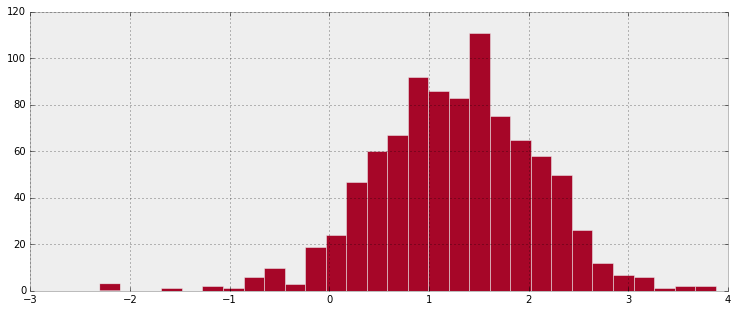

In [7]:
## Distribution of radon levels in Minnesota (log scale)
figsize(12.5, 5)
fig = _data.activity.apply(lambda x: np.log(x + 0.1)).hist(bins = 30,  color = colors[1])

In [8]:
## Prepare the data
_data['log_radon'] = _data['log_radon'].astype(theano.config.floatX)

## mn counties
county_names = _data.county.unique()
county_idx = _data.county_code.values
n_counties = len(_data.county.unique())

##Keep the interest : Bad! 
data_final= _data[['county', 'log_radon', 'floor']]
data_final.head()

,county,log_radon,floor
0,AITKIN,0.832909,1
1,AITKIN,0.832909,0
2,AITKIN,1.098612,0
3,AITKIN,0.095310,0
4,ANOKA,1.163151,0


### The Models 

#### Pooling of measurements : 
We can try to estimate one big regression to asses the influence of a basement across all counties:
$$\begin{aligned}
  radom_{i,c} = \alpha + \beta * floor_{i,c} + \epsilon 
\end{aligned}$$
where $i$ represent the measurement, $c$ the county and floor contains a 0 or 1.
Critical, we are only estimating one $intercept$ and one $slope$ for all measurements over all counties pooled together as illustrating the graphic below ( $\theta$ represent ($\alpha, \beta$) in our case and $y_{i}$ are the measurements of the $i$th county)
![pooled](http://f.cl.ly/items/0R1W063h1h0W2M2C0S3M/Screen%20Shot%202013-10-10%20at%208.22.21%20AM.png)

#### Unpooled measurements :separate regressions
But if we are interested in wether different counties actually have different relationships($slope$) and different base-rates  ($intercept$), the we can estimate $n$(number of counties) different regressions, in math speaking :
$$\begin{aligned}
  radon_{i,c} = \alpha_{c} + \beta_{c}*floor_{i,c} + \epsilon_{c}
\end{aligned}$$
![unpooled](http://f.cl.ly/items/38020n2t2Y2b1p3t0B0e/Screen%20Shot%202013-10-10%20at%208.23.36%20AM.png)

This is the extreme opposite model, where above we assumed all counties are exactly the same, here we are saying that the share no similarities.
Due to the $law$ $of$ $large$ $number$ seen before, this type of model can be very noisy when we have little data per county, as is the case in this dataset

#### Partial Pooling : Hierarchical regression aka, the best of both worlds
Fortunately, there is a middle ground to both of these approach. Specifically, we may assume that while $\alpha_{s}$ and $\beta_{s}$ are different for each county as in the unpooled case, <b>the coefficients all share similarity.</b>
We can model this by assuming that each individual coefficient comes from a common group distribution : 


$$\begin{aligned}
  \alpha_{c} &\sim \mathcal{N}(\mu_{\alpha}, \sigma_\alpha^{2}) \\
  \beta_{c} &\sim \mathcal{N}(\beta_{\beta}, \sigma_\beta^{2}) \\
\end{aligned}$$

This model is called a $multilevel$, $hierarchical$ or $partial$ $pooling$ modeling
![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)

## Probabilistic programming : 

In [9]:
## Unpooled//non-multilevel model

with pm.Model() as upooled_model:
    
    ##independent paramter for each county
    
    a = pm.Normal("a", mu = 0, sd = 100, shape = n_counties)
    b = pm.Normal("b", mu = 0, sd = 100, shape = n_counties)
    
    ## Model error
    
    eps = pm.HalfCauchy("eps", 5)
    
    ## Model predictionof radon
    ## a [county_idx] translates to a [0, 0, 0, 1, 1, 1, ...]
    ## we thus link multiple  household measures of a county to its coefficients
    
    radon_est = a[county_idx] + b[county_idx]*data_final.floor.values
    
    ##Likelihood
    
    likelihood = pm.Normal("obs", mu = radon_est, sd = eps, observed = data_final.log_radon.values)
    
    ##Optimization
    
    start = pm.find_MAP(fmin = scipy.optimize.fmin_l_bfgs_b)
    step = pm.NUTS(scaling = start)
    
    ##Sampling
    
    trace_unpooled = pm.sample(20000, step = step, start = start)
    burned_unpooled = trace_unpooled[10000:]

100%|██████████| 20000/20000 [00:57<00:00, 345.63it/s]


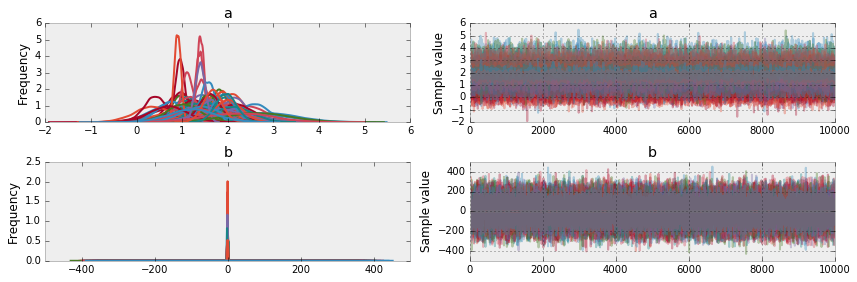

In [10]:
pm.plots.traceplot(trace = burned_unpooled, varnames = ["a", "b"]);

In [11]:
with pm.Model() as multilevel_model:
    
    ## Hyperpriors for group nodes
    
    mu_a = pm.Normal("mu_a", mu = 0., sd = 100**2)
    sigma_a = pm.HalfCauchy("sigma_a", 5)
    
    mu_b = pm.Normal("mu_b", mu = 0, sd = 100**2)
    sigma_b = pm.HalfCauchy("sigma_b", 5)
    
    ##  Intercept for each county, dustributed around group mean mu_a
    ## above we just ste mu and sd to a fixed value while here we plug in
    ## a common group distribution for all a and b(which are vectors of length n_counties)
    
    a = pm.Normal("a", mu = mu_a, sd = sigma_a, shape = n_counties)
    
    ## Intercept for each county, distributed around group mean mu_a
    
    b = pm.Normal("b",mu = mu_b, sd = sigma_b, shape = n_counties)
    
    ## Model error
    
    eps = pm.HalfCauchy("eps", 5)
    
    radon_est = a[county_idx] + b[county_idx] * data_final.floor.values
    
    ## Likelihood
    likelihood = pm.Normal("radon_like", mu = radon_est, sd = eps, observed = data_final.log_radon.values)

In [12]:
with multilevel_model:
    start = pm.find_MAP(fmin = scipy.optimize.fmin_l_bfgs_b)
    step = pm.NUTS(scaling = start)
    multilevel_trace = pm.sample(40000, step = step, start = start)
    burned_multilevel = multilevel_trace[20000:]

100%|██████████| 40000/40000 [00:20<00:00, 1985.55it/s]


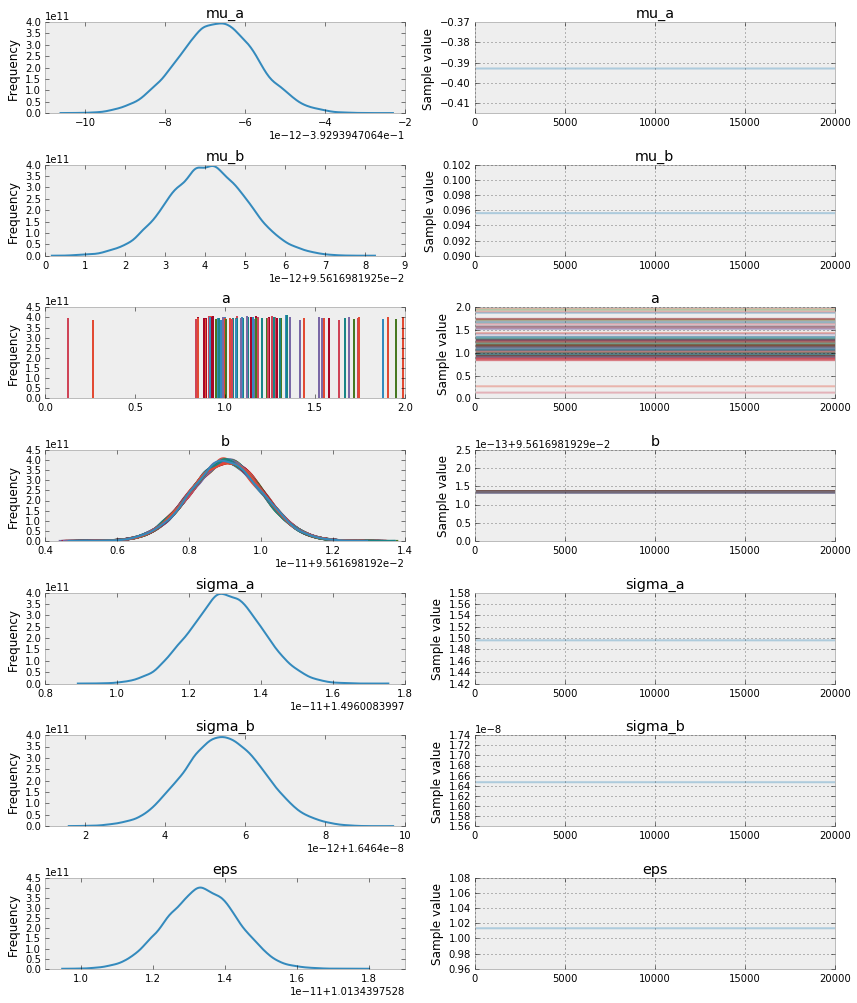

In [13]:
pm.plots.traceplot(trace = burned_multilevel);

### TODO:
1. Estimate the Root Mean square Deviation for both above model
2. recompute the optimization using advi
3. Add and do this for A|B testing https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/
4. this repos for both bayesian and ML https://github.com/dsaber

### Hierarchical Partial Pooling

Suppose we are tasked with estimating baseball batting skills for several players. One such $performance$ $metric$ is batting average.
Since players play a different number of games and bat in different positions in the order, each player has a different number of at-bats. However, we wants to estimate the skill of all players, including those with a relatively small number of batting opportunities.
So suppose a player come to bat 4 times, and never hit the ball, are they a bad player ?

##### Approach
We will estimate the batting average for each player. Having estimated the averages across all players in the datasets ,we can use this information to inform an estimate of an additional player, for which there is a little data(4 at bats).
As they exercice above in absence of Bayesian hierarchical model, there are two approaches for this problem:
    1. Independently compute  batting average for each player <b><i>(no polling)</i></b>
    2. Compute an overall average, under the assumption that everyone has the same underlying average <b><i>(complete polling)</i></b>

Of course, neither approach is realistic. Clearly, all players aren’t equally skilled hitters, so the global average is implausible. At the same time, professional baseball players are similar in many ways, so their averages aren’t entirely independent either.

It may be possible to cluster groups of “similar” players, and estimate group averages, but using a hierarchical modeling approach is a natural way of sharing information that does not involve identifying a hoc clusters.

The idea of hierarchical partial pooling is to model the global performance, and use that estimate to parameterize a population of players that accounts for differences among the players’ performances. This tradeoff between global and individual performance will be automatically tuned by the model. Also, uncertainty due to different number of at bats for each player (i.e. information) will be automatically accounted for, by shrinking those estimates closer to the global mean.

For dept detail refer to http://mc-stan.org/documentation/case-studies/pool-binary-trials.html

In [14]:
## Load the data
data = pd.read_table("/Users/Kenneth-Aristide/anaconda3/bin/python_prog/pymc3/training/data/EfronMorrisBB.txt",
                     sep = "\t")
data.tail()

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonHits,SeasonAverage
13,Del,Unser,45,10,0.222,277,0.2635,322,83,0.258
14,Billy,Williams,45,10,0.222,591,0.3299,636,205,0.251
15,Bert,Campaneris,45,9,0.200,558,0.2849,603,168,0.279
16,Thurman,Munson,45,8,0.178,408,0.3162,453,137,0.302
17,Max,Alvis,45,7,0.156,70,0.2000,115,21,0.183


In [15]:
## Separate the number of trials and hits
at_bats, hits = data[["At-Bats", "Hits"]].values.T

Now let’s develop a generative model for these data.

We will assume that there exists a hidden factor ($\phi$ : phi) related to the expected performance for all players (not limited to our 18). Since the population mean is an unknown value between 0 and 1, it must be bounded from below and above. Also, we assume that nothing is known about global average. Hence, a natural choice for a prior distribution is <b>the uniform distribution</b>.

Next, we introduce a hyperparameter kappa : $\kappa$ to account for the <b>variance</b> in the population batting averages, for which we will use a <b><i>bounded Pareto distribution</i></b>. This will ensure that <i>the estimated value falls within reasonable bounds</i>. These hyperparameters will be, in turn, used to parameterize a <b>beta distribution, which is ideal for modeling quantities on the unit interval</b>. The beta distribution is typically parameterized via a $scale$ and $shape$ parameter, it may also be parametrized in terms of its mean $\mu$∈[0,1]
and sample size (a proxy for variance) $\kappa$ = $\alpha$ + $\beta$ ($\kappa$ > 0)

.

The final step is to specify a sampling distribution for the data (hit or miss) for every player, using a <b>Binomial distribution</b>. This is where the data are brought to bear on the model.

In [16]:
N = len(hits)

BoundedKappa = pm.Bound( pm.Pareto)

with pm.Model() as baseball_model:
    
    ## uninformative weakly prior
    phi = pm.Uniform("phi", lower = 0.0, upper = 1.0)
    kappa = BoundedKappa("kappa", alpha = 1.000001, m = 1.5)
    thetas = pm.Beta("thetas", alpha = phi * kappa, beta = (1. - phi) * kappa, shape = N)
    
    y = pm.Binomial("y", n = at_bats, p = thetas, observed = hits)
    
    ## Our original question was with regard to the true batting average for a player with only 4 at bats and no hits 
    #what his mean
    ## Let's add that
    theta_new = pm.Beta("theta_new", alpha = phi*kappa, beta = (1 - phi) * kappa)
    y_new = pm.Binomial("y_new", n = 4, p = theta_new, observed = 0)
    
    ## Optimization
    #start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    #step = pm.NUTS()
    
    ## Sampling
    trace = pm.sample(2000, init = None)
    burned_baseball = trace[1000:]

100%|██████████| 2000/2000 [01:29<00:00, 22.32it/s]


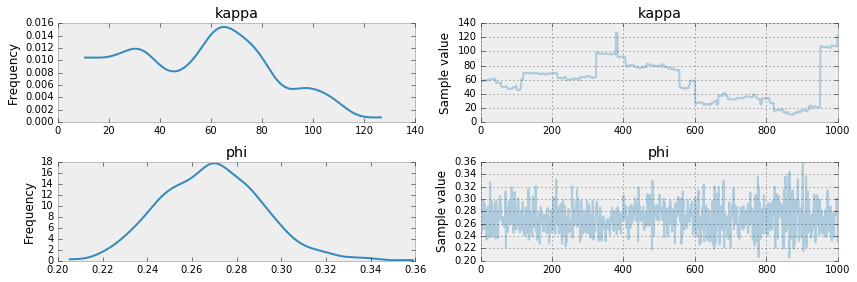

In [17]:
pm.plots.traceplot(trace = burned_baseball, varnames = ["kappa", "phi"]);

Hence, the population mean batting average is in the 0.22-0.31 range, with an expected value of around 0.26.

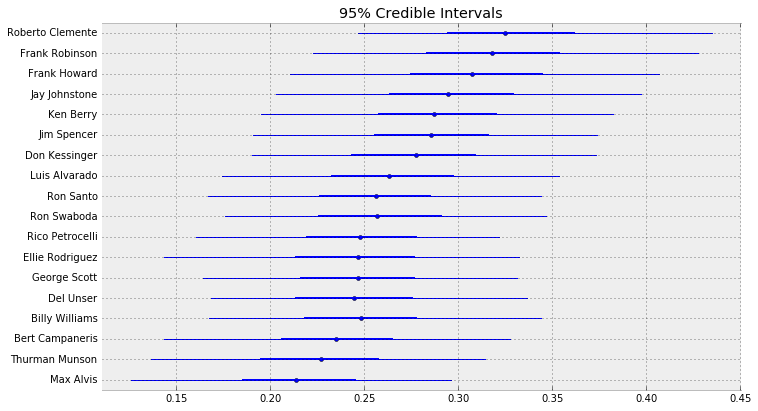

In [18]:
player_names = data.apply(lambda x : x.FirstName + ' ' + x.LastName, axis = 1)
figsize(12.5, 6)
pm.forestplot(burned_baseball, varnames = ["thetas"], ylabels = player_names);

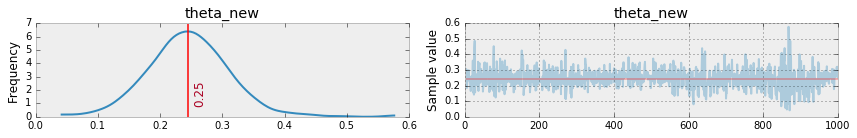

In [19]:
## Finally, let’s get the estimate for our 0-for-4 player:
ax = pm.plots.traceplot(trace = burned_baseball, varnames = ["theta_new"],
                  lines = {k: v['mean'] for k, v in pm.df_summary(trace = burned_baseball,
                                                                  varnames = ["theta_new"]).iterrows()});
for i, mn in enumerate(pm.df_summary(trace = burned_baseball, varnames = ["theta_new"])['mean']):
    ax[i, 0].annotate("{:.2f}".format(mn), xy = (mn, 0), xycoords = "data", xytext = (5, 10),
                     textcoords = "offset points", rotation = 90,va= "bottom", fontsize = "large",
                     color = "#AA0022")

TODO :
    1. make the plot with the red line
    2. figure out how to predict mean for a new player, do we have to re-run the entire models adding the player ?
    
    
    
Notice that, despite the fact our additional player did not get any hits, the estimate of his average is not zero – zero is not even a highly-probably value. This is because we are assuming that the player is drawn from a population of players with a distribution specified by our estimated hyperparemeters. However, the estimated mean for this player is toward the low end of the means for the players in our dataset, indicating that the 4 at-bats contributed some information toward the estimate.